# Explainer Notebook
This notebook provides the background and our personal motivations for the development of our final project.

Our final project (Article titled **"What Gets The People Going?"**) is an examination of pedestrian activity in inner city Melbourne in conjugation with different weather types. Additionally, the article features a predictive model of pedestrian activity given certain weather inputs.

## Motivation
### What is our dataset?
We've used three datasets:
1. City of Melbourne's Pedestrian Counting System [Source](https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Monthly-counts-per-hour/b2ak-trbp?src=featured_banner)
2. The associated Pedestrian Counting System Sensor location dataset [Source](https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Sensor-Locations/h57g-5234)
3. Meteostat's weather data from a Melbourne weather station [Source](https://meteostat.net/en/station/94866?t=2015-01-01/2021-12-31)

### Why did we choose this dataset?
We became particularly interested in the Pedestrian activity dataset when we found it and decided we would like to center our project around it. To this end we discussed different ways to cross the data with something else to provide a social or green background to our project.

Ultimately we decided on weather! We thought exploring any eventual corellations between weather and pedestrian activity would make for some interesting discourse.

Then we could look at how temperature, wind and rainfall affected people's decision to walk.
### What was our goal for the end-user experience?
Hard to specify exactly what we wanted for our end-user since we could not tell beforehand what the data would show, but it would be a lie not to say that we were expecting some interesting corellations to point at. Especially rainfall and temperature seemed like factors that could widely affect pedestrian activity, and we wished to point these out to the user in a sort of build-up, where we at first explore the pedestrian data, then cross it with the weather data to suddenly see some cool trends.

Finally, we would have liked to be able to show some rudimentary results of a predictive model, to engage the user in a small if interesting quirky forecasting; "Look, we can tell how many people will walk depending on the weather!"
While by itself somewhat uninteresting, it would at least give rise to some discussion of how such data could be used in events, campaigns and other minor social 'manipulation'.

## Basic Stats
### Our choices in data cleaning and preprocessing
The pedestrian and sensor location data was already in a clean shape as we got them. However, combining them to get the locations for each sensor used in the pedestrian data set, we found out that not all sensors used there had an entry in the locations data set. Only 78 out of the 81 sensors used in the pedestrian dataset had data for locations. Therfore, we ignored the rows which are connected to the one of the three missing sensors.

Regarding the weather data, we focused only on columns regarding temperature, wind and precipitation since the other columns had to many unknown values. Futher, we dropped the rows with unknown values to get a clean data set for the weather data.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import folium
from folium import plugins
from folium.plugins import HeatMap

In [2]:
# The location data set of the sensors.
df_s = pd.read_csv('https://www.student.dtu.dk/~s212220/socialData2022/Data/Pedestrian_Counting_System_-_Sensor_Locations.csv')

In [3]:
# The pedestrian data set
df_p = pd.read_csv('https://www.student.dtu.dk/~s212220/socialData2022/Data/Pedestrian_Counting_System_-_Monthly__counts_per_hour_.csv')

In [4]:
# Finding the 3 missing sensors
for s_id in df_p.Sensor_ID.unique():
    if s_id not in df_s.sensor_id.unique():
        print(s_id)

84
85
86


In [5]:
# Cleaning the pedestrian data - deleting the missing sensors activity
df_p = df_p[(df_p.Sensor_ID != 84) & (df_p.Sensor_ID != 85) & (df_p.Sensor_ID != 86)]

In [6]:
# The weather data set
df_w = pd.read_csv('https://www.student.dtu.dk/~s212220/socialData2022/Data/weather_melbourne.csv')

In [7]:
# Cleaning the weather data - dropping snow, wpgt, tsun, pres due to too many missing values
df_w = df_w.drop(['snow', 'wpgt', 'tsun', 'pres'], axis=1)
# Drop NaN values of the rest of the culomns
df_w = df_w.dropna()

### A short section on the dataset stats, containing key points/plots from our exploratory data analysis.

Let's start with the location of the sensors. It contains 78 rows coresponding to the amount of sensors. next to the location, we can find a description containing the street names the sensor is located on. Futhermore, we can find the ids of the sensors and their installation date in the data set.

In [8]:
# The maps shows the location of the sensors.
map_loc = folium.Map(location=[-37.8140000, 144.9633200],tiles = "Stamen Toner",
                    zoom_start = 14) 

# Ensure you're handing it floats
df_s['latitude'] = df_s['latitude'].astype(float)
df_s['longitude'] = df_s['longitude'].astype(float)

for index, row in df_s.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup=row['sensor_description']).add_to(map_loc)

# Styling title
loc = 'Corpus Christi'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>Locations of Sensors</b></h3>
             '''.format(loc) 
map_loc.get_root().html.add_child(folium.Element(title_html))

# Display the map
map_loc

The interactive map shows all the locations of the different sensors collecting the pedestrian data. As visible, most of the sensors are located in the inner city and that's where our focus is directed in the project. Each of the sensors provides a description containing the street or corner where they are located. One outline can be noticed when zooming out on the map. It's the sensor located on the corner of Macaulay Rd and Bellair St. As we are focusing on the city center and - by having a look at the data - since it was installed at the end of the timeframe of our pedestrian data set on 2021/02/20, we still leave it in the data set but our later maps may not focus on showing it as well.

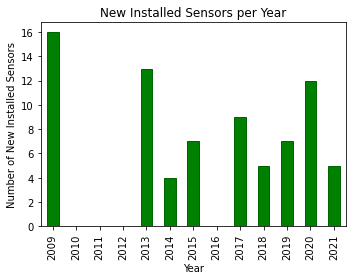

In [9]:
# finding the year of the installation
df_s['Year'] = pd.DatetimeIndex(df_s['installation_date']).year
# adding missing years in range(2009, 2022)
df = pd.DataFrame({'Year': [2010, 2011, 2012, 2016]})
df_s_y = df_s.append(df, ignore_index = True)

# Plot that shows new introduced sensors per year
fig = plt.figure(figsize=(5, 4))
df_s_y.groupby(['Year']).count()['sensor_id'].plot \
    .bar(title='New Installed Sensors per Year', x=range(df_s['Year'].min(),df_s['Year'].max() + 1),
         edgecolor='darkgreen', color = 'green')
# Styling
plt.ylabel('Number of New Installed Sensors');

plt.tight_layout() 
plt.show()

The plot aboth shows when sensors were installed over the years. As we know, covid hit in 2020 (more about this later) and therefore, we used for most of the plots coming up the year 2019. It includes the most data since there were 54 sensors when the year started.

After cleaning the pedestrian data set, it has 4172305 rows containing the date and time for each entry and the amount of people who walked by this sensor in the given hour. It includes the time frame of 2009 until February 2022.

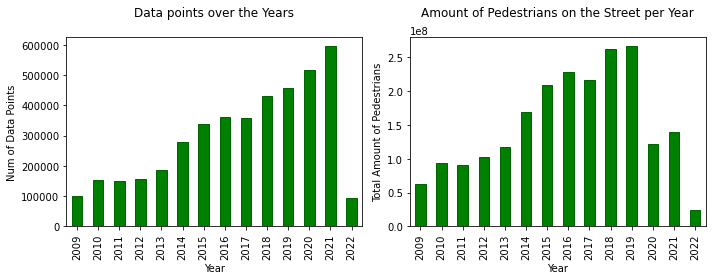

In [10]:
# Plot shows the data points over the year and the amount of pedestrians walking
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
df_p.groupby('Year').count()['ID'].plot \
    .bar(title='Data points over the Years\n', 
         ax = ax[0], edgecolor='darkgreen', color = 'green')
df_p.groupby(['Year']).sum()['Hourly_Counts'].plot \
    .bar(title='Amount of Pedestrians on the Street per Year\n', 
         ax=ax[1], edgecolor='darkgreen', color = 'green')

# Styling
ax[0].set_ylabel('Num of Data Points');
ax[1].set_ylabel('Total Amount of Pedestrians');

plt.tight_layout() 
plt.show()

The collection of data grow over the years for the pedestrian data set. This can be compared with the plot aboth showing the installed sensors. Whenever no new sensors where installed, the collection of data languishs. The amount of pedestrians on the street is mainly growing due to more datapoints but we can see a few unexpected outliners. Looking at 2020 and 2021, we can see a huge drop in the amount of pedestrians on the street while the data points are growing. This is due to covid - a pandemic which hitted Melbourne at around March 2020 [Source](https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Victoria)

Let's have a look at the weather data now. It includes the time frame from 2015 until 2019.

TODO explain weather data ( maybe with a plot showing the average temperature, rain over a year seperated into months?

## Data Analysis
* Discuss our data analysis and explain what we've learned about the dataset *
TODO

First, we are going to have a closer look at the connection between the pedestrian data and the location of the sensors. We choose a interactive heatmap for this analysis. The selected year is 2019 and we are going to compare January with July since they are opposide months, one in summer and the other one in winter. We plot the whole month.

In [13]:
# getting data frames from January and July in 2019
df_p_19 = df_p.loc[df_p['Year'] == 2019]
df_p_19_ja = df_p_19.loc[df_p_19['Month'] == 'January']
df_p_19_ju = df_p_19.loc[df_p_19['Month'] == 'July']
df_s_location = df_s[['sensor_id', 'latitude', 'longitude']]

In [14]:
# merging the january dataset with the sensors location
df_p_19_ja_g = df_p_19_ja.groupby(['Sensor_ID']).sum()
df_p_19_ja_g.columns = df_p_19_ja_g.columns.str.replace('Hourly_Counts', 'Monthly_Counts')
df_p_19_ja_g = pd.merge(df_p_19_ja_g, df_s_location, left_on="Sensor_ID", right_on="sensor_id").drop('sensor_id', axis=1)
# normalizing the monthly count such that we can easier compute the heat map
MC_sum_ja = df_p_19_ja_g['Monthly_Counts'].sum()
df_p_19_ja_g.Monthly_Counts = (df_p_19_ja_g.Monthly_Counts / MC_sum_ja) * 10000

# merging the july dataset with the sensors location
df_p_19_ju_g = df_p_19_ju.groupby(['Sensor_ID']).sum()
df_p_19_ju_g.columns = df_p_19_ju_g.columns.str.replace('Hourly_Counts', 'Monthly_Counts')
df_p_19_ju_g = pd.merge(df_p_19_ju_g, df_s_location, left_on="Sensor_ID", right_on="sensor_id").drop('sensor_id', axis=1)
# normalizing the monthly count such that we can easier compute the heat map
MC_sum_ju = df_p_19_ju_g['Monthly_Counts'].sum()
df_p_19_ju_g.Monthly_Counts = (df_p_19_ju_g.Monthly_Counts / MC_sum_ju) * 10000

In [22]:
# creating the heat map for january
map_january = folium.Map(location=[-37.8140000, 144.9633200],tiles = "Stamen Toner",
                    zoom_start = 14) 

# Ensure you're handing it floats
df_p_19_ja_g['latitude'] = df_p_19_ja_g['latitude'].astype(float)
df_p_19_ja_g['longitude'] = df_p_19_ja_g['longitude'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs
heat_df_ja = pd.DataFrame(columns=['latitude',
                    'longitude'])
for index, row in df_p_19_ja_g.iterrows():
    for index in range(0, int(row['Monthly_Counts'])):
        df_row = pd.DataFrame([[row['latitude'],row['longitude']]], columns=['latitude', 'longitude'])
        heat_df_ja = heat_df_ja.append(df_row, ignore_index = True)

# List comprehension to make out list of lists
heat_data_ja = [[row['latitude'],row['longitude']] for index, row in heat_df_ja.iterrows()]

# Styling
loc = 'Corpus Christi'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>Normalized Amount of Pedestrians in January</b></h3>
             '''.format(loc) 
map_january.get_root().html.add_child(folium.Element(title_html))

# Marking outliners
folium.CircleMarker([-37.820178, 144.965089], radius=20, 
                    popup='Southbank',color='red').add_to(map_january)

# Plot it on the map
HeatMap(heat_data_ja, blur=10, radius=15).add_to(map_january)

# Display the map
map_january

In [21]:
# creating the heat map for july
map_july = folium.Map(location=[-37.8140000, 144.9633200],tiles = "Stamen Toner",
                    zoom_start = 14) 

# Ensure you're handing it floats
df_p_19_ju_g['latitude'] = df_p_19_ju_g['latitude'].astype(float)
df_p_19_ju_g['longitude'] = df_p_19_ju_g['longitude'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs
heat_df_ju = pd.DataFrame(columns=['latitude',
                    'longitude'])
for index, row in df_p_19_ju_g.iterrows():
    for index in range(0, int(row['Monthly_Counts'])):
        df_row = pd.DataFrame([[row['latitude'],row['longitude']]], columns=['latitude', 'longitude'])
        heat_df_ju = heat_df_ju.append(df_row, ignore_index = True)

# List comprehension to make out list of lists
heat_data_ju = [[row['latitude'],row['longitude']] for index, row in heat_df_ju.iterrows()]

# Styling
loc = 'Corpus Christi'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>Normalized Amount of Pedestrians in July</b></h3>
             '''.format(loc) 
map_july.get_root().html.add_child(folium.Element(title_html))

# Marking outliners
folium.CircleMarker([-37.817864, 144.965068], radius=20, 
                    popup='Flinders St - Elizabeth St (East)',color='red').add_to(map_july)
folium.CircleMarker([-37.818990, 144.954507], radius=20, 
                    popup='Spencer St - Collins St',color='red').add_to(map_july)

# Plot it on the map
HeatMap(heat_data_ju, blur=10, radius=15).add_to(map_july)

# Display the map
map_july

The data used for these heatmaps was normalized to skale down the amount of datapoints. As expected the city center is the most flourishing point which can be explained by a lot of sensors and a main attraction throughout the year. Two main points are outstanding between January and July. 

In January the sensor in Southbank is high active meaning recognized a lot of pedestrians while its nearly not visible in July. The people seamed to stay on the other side of the river since a sensor at Flinders St - Elizabeth St (East) seams to recognize a lot more people. The Southbank is a promenade which "has many cafes, restaurants, shops, upmarket hotels, offices, public art and modern apartments." [Source](https://www.melbourne.vic.gov.au/about-melbourne/melbourne-profile/suburbs/Pages/Southbank.aspx) This explains a lot of activity in summer and less in winter. 

In July the two sensors at Spencer St - Collins St seam to more active than in January. looking more closely at both hot spots in July, we can see that they are both close to train stations (Southern Cross and Flinders Street). In winter people taking more public transport than in summer but they still want to go to the city center. Therfore, the sensors close to the train stations on the side towards the city center are recognizing more people walking by.

Next up, we looked more deeply at the  pedestrian data set and what it tells us about peoples behaviour.

TODO including the weekend times plots

## Genre
### Which genre of story did we use?
We decided to run with the magazine style. Truthfully, it was because this way we could best work on our graphs to the best of our ability without having to worry with implementing them in a third party platform/website structure. We would have liked to just focus on the tools we had been taught during class, and the magazine style article allowed us to do just that.

After the decision, however, we leveraged the use of the magazine style to lay additional weight on the narrative part of the article. We could find literary ways to engage with the user instead of attempting to wow them with flashy web parts.

We then supplemented this with some streamlined, light and pretty plots to provide the users with easily digestible 'breaks'.

### Which tools did we use from each of the 3 categories of Visual Narrative. Why?
A **consistent visual platform** is used, though its use was rather subconscious than decided. Plots with similar styles and an overall sense of 'appearance' for the article as a whole is naturally appealing and was a simple goal to strive for.

We use little explosive highlighting, but did make use of some literary highlighting tools. Giving the introductory text a thick font leads the user into the article and the traditional use of chapters and paragraphs makes reading less strenuous.

Due to the magazine style of our article and the conservative presentation of our plots, other visual tools were not quite applicable.

### Which tools did we use from each of the 3 categories of Narrative Structure. Why?
Our intent was to write with a **User Directed Path**. We supposed we could lead the user through the data from the simplest plots first, for example simple plots over pedestrian activity across the years, into heavier material such as corellations, to finally conclude with the most technically complicated data; our predictive model. This way we figured that a regular reader would be engaged by the simple premises early on, and hang on through the slightly tougher material throughout.

Additionally, a reader unintestered in heavier material would still be have followed along for some of the article and caught at least some of the interesting points we would like to send across.

Overall, the **interactivity** of our narrative structure is lacklustre, but we don't find it to much of a detriment - the goal of our article is to guide the reader through literary structure instead of interactive tools.

We make use of **captions and headlines** to make the article easier to digest. Additionally, while we actively *avoid* drawing on **repeated comments** (due to the nature of the topic being, in our opinion, lightweight and therefore not requiring repitition for understanding) we *do* lean exploit the **introductory text** and later short **synopsis**, concealed as narrative devices to first greet the reader and subsequently wean them off the text.

## Visualizations
### Explain the visualizations we've chosen.
TODO
### Why are they right for the story you want to tell?
TODO

## Discussion
### What went well?
TODO
### What is still missing? What could be improved? Why?
TODO

## Contributions
TODO